# Importing files and Required libraries

In [2]:
import argparse
import torch
import torch.jit
import keras
from path import Path
from dataloader import DataLoaderImgFile
from eval2 import evaluate
from net import WordDetectorNet
from visualization import visualize_and_plot
import cv2

In [4]:
import torch
from PIL import Image
from model import Model
from utils import AttnLabelConverter, Averager
#import torchvision.utils as vutils
from dataset import hierarchical_dataset, AlignCollate
#from torchvision.transforms import ToTensor
from utils import AttnLabelConverter  # Make sure to import the appropriate converter
from torchvision import transforms
import os


#import the NN
net = WordDetectorNet()
net.load_state_dict(torch.load('model/weights', map_location='cpu'))
net.eval()

# Setting up hyperparametrs for Attention-HTR (Recognition model)


In [6]:
class Options:
    def __init__(self):
        self.eval_data = None
        self.benchmark_all_eval = False
        self.workers = 4
        self.batch_size = 192
        self.saved_model = None
        self.batch_max_length = 25
        self.imgH = 32
        self.imgW = 100
        self.rgb = False
        self.character = '0123456789abcdefghijklmnopqrstuvwxyz'
        self.sensitive = False
        self.PAD = False
        self.data_filtering_off = False
        self.baiduCTC = False
        self.Transformation = None
        self.FeatureExtraction = None
        self.SequenceModeling = None
        self.Prediction = None
        self.num_fiducial = 20
        self.input_channel = 1
        self.output_channel = 512
        self.hidden_size = 256

# Create an instance of the Options class
opt = Options()

# Set the attributes of the opt instance based on the parsed arguments
opt.eval_data = 'path_to_evaluation_data'
opt.benchmark_all_eval = True  # or False
opt.workers = 0
opt.batch_size = 192
opt.saved_model = 'models/AttentionHTR-General-sensitive.pth'
opt.batch_max_length = 25
opt.imgH = 32
opt.imgW = 100
opt.rgb = False
opt.character = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
opt.sensitive = True
opt.PAD = False
opt.data_filtering_off = False
opt.baiduCTC = False
opt.Transformation = 'TPS'  # or ''
opt.FeatureExtraction = 'ResNet'  # or 'RCNN' or 'VGG'
opt.SequenceModeling = 'BiLSTM'  # or ''
opt.Prediction = 'Attn'  # or 'Attn'
opt.num_fiducial = 20
opt.input_channel = 1
opt.output_channel = 512
opt.hidden_size = 256


# Architecture for Attention-HTR model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)
print(opt.num_class)
# Load the pre-trained model
model_path = 'models/AttentionHTR-General-sensitive.pth'
AN = Model(opt)
opt.exp_name = '_'.join(opt.saved_model.split('/')[1:])
AN = torch.nn.DataParallel(AN).to(device)
print('model input parameters', opt.imgH, opt.imgW, opt.num_fiducial, opt.input_channel, opt.output_channel,
          opt.hidden_size, opt.num_class, opt.batch_max_length, opt.Transformation, opt.FeatureExtraction,
          opt.SequenceModeling, opt.Prediction)
AN.load_state_dict(torch.load(model_path, map_location=device))
AN.eval()

96
model input parameters 32 100 20 1 512 256 96 25 TPS ResNet BiLSTM Attn


DataParallel(
  (module): Model(
    (Transformation): TPS_SpatialTransformerNetwork(
      (LocalizationNetwork): LocalizationNetwork(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (10): ReLU

# Pipeline for hybrid architecture (segmentation and recognition)

In [14]:
def extract_entities(text):
     for sent in nltk.sent_tokenize(text):
         for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
             if hasattr(chunk, 'node'):
                print(chunk.node, ' '.join(c[0] for c in chunk.leaves()))



No of Words Detected: 104


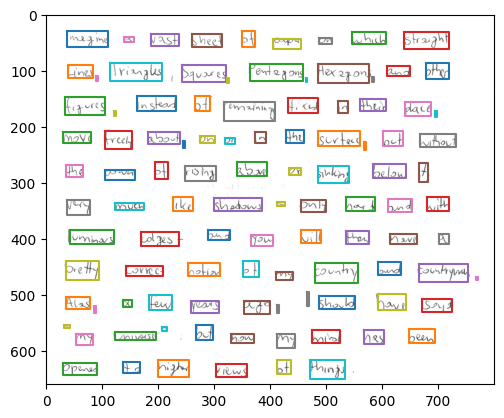

meine vast seat pays which straight 
Lines Triangles Squares None hexagon and other 
figures instead remaining fixe their place 

move freely about surfer best without 
power rising above sinking below 
very ike shadows only how None with 
minas edges anand You will then have 
pretty None notion country and None 
Alas few years aka should have save 

universe how mils has been 
opened higher view things 

In [14]:
from spellchecker import SpellChecker
loader = DataLoaderImgFile(Path('test/'), net.input_size, "cpu")   
res = evaluate(net, loader, max_aabbs=1000)

def perform_inference(model, converter, image, opt):
    """ Perform inference on a single image """
    
    transform = transforms.Compose([
transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Example normalization values
    ])
    
    image = transform(image).unsqueeze(0).to(device)
    # You might need to adjust input image preprocessing according to your model's requirements

    model.eval()
    with torch.no_grad():
        preds = model(image, None, is_train=False)

        preds = preds[:, :opt.batch_max_length - 1, :]

        _, preds_index = preds.max(2)

        preds_index = preds_index[preds_index != 1]

        preds_index = preds_index.unsqueeze(0)

        preds_str = converter.decode(preds_index, torch.IntTensor([opt.batch_max_length] * preds.size(0)))

        pred_text = "".join(preds_str)
        corrected_word = SpellChecker().correction(pred_text)
        print(corrected_word, end=" ")

def Preprocess_inference(aabb):
    x = [int(aabb.xmin), int(aabb.xmin), int(aabb.xmax), int(aabb.xmax), int(aabb.xmin)]
    y = [int(aabb.ymin), int(aabb.ymax), int(aabb.ymax), int(aabb.ymin), int(aabb.ymin)]
    crop_left = min(x)
    crop_top = min(y)
    crop_right = max(x)
    crop_bottom = max(y)
    roi = img[crop_top:crop_bottom, crop_left:crop_right]
    height, width = roi.shape[:2]
    minimum_size = (14,34)
    # Check if the image is large enough
    if width >= minimum_size[1] and height >= minimum_size[0]:
        pred_text = perform_inference(AN, converter, roi, opt)
    
#sorting as a complete paragraph 

for i, (img, aabbs) in enumerate(zip(res.batch_imgs, res.batch_aabbs)):
        f = loader.get_scale_factor(i)
        aabbs = [aabb.scale(1 / f, 1 / f) for aabb in aabbs]
        img = loader.get_original_img(i)
        print("")
        print(f"No of Words Detected: {len(aabbs)}")
        visualize_and_plot(img, aabbs)
        dyn_ymin = aabbs[0].ymin
        dyn_ymax = aabbs[0].ymax
        line= []
        for word in aabbs:
            # last line logic
            if aabbs.index(word) == len(aabbs) -1:
                line.append(word)
                line = sorted(line,key=lambda i: (i.xmax))
                for fin_words in line:
                    Preprocess_inference(fin_words)
                    
            # Until last line
            elif  word.ymin - dyn_ymin <= dyn_ymax - dyn_ymin :
                line.append(word)
                
            #After each line 
            else:
                line = sorted(line,key=lambda j: (j.xmax))
                for sor_words in line:
                    Preprocess_inference(sor_words)
                print("")
                line = []
                line.append(word)
                dyn_ymin = word.ymin
                dyn_ymax = word.ymax

# Sorting algorithm for bounding boxes of segmentation model

In [ ]:
#sorting algorithm for educational purpose

# First sort via height which is already done

dyn_ymin = aabbs[0].ymin
dyn_ymax = aabbs[0].ymax
line=[]
for aabb in aabbs:
    if aabbs.index(aabb) == len(aabbs) - 1:
        line.append(aabb)
        print(line)
        
    elif  aabb.ymin - dyn_ymin <= dyn_ymax - dyn_ymin:
        line.append(aabb)
    else:
        print(line)
        dyn_ymin = aabb.ymin
        dyn_ymax = aabb.ymax
        line = []